In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
import corner
import optax

In [2]:
key = jax.random.PRNGKey(34782)

# Mean-Field Approximation via ADAM & SGD

tutorial from blog https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/

Forward model

$$ y = F(x, \theta) + \sigma \, n, \quad n \sim N(0,1)$$ 
$$ y|x = \frac{y-F(x, \theta)}{\sigma} = n, \quad n \sim N(0,1)$$ 

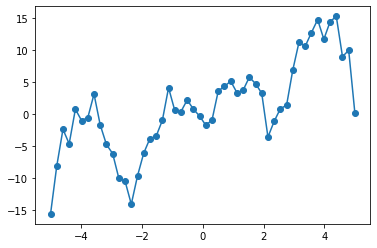

In [143]:
n_data = 50
x = jnp.linspace(-5,5,n_data)
sigma = 2.
n = jax.random.normal(key, (n_data,))
theta_truth = 2.

def f(theta):
    return theta*x*jnp.sin(2*x) + jnp.cos(theta**2*x) + theta*x

y = f(theta_truth) + sigma * n

plt.plot(x,y, 'o-');

In [144]:
def neg_log_prior(theta):
    return theta**2/2

def neg_log_likelihood(theta):
    return jnp.sum((y-f(theta))**2)/(2*sigma**2)
#     return jnp.sum((y-f(theta))**2/(2*x*sigma**2))/(2*sigma**2)

def neg_log_posterior(theta):
    return neg_log_prior(theta) + neg_log_likelihood(theta)

def generate_theta(key, gauss_param, n_batch):
    mean, log_std = gauss_param
    std = jnp.exp(log_std) + 1e-5
    return mean, std, mean + std * jax.random.normal(key, (n_batch,))

def neg_log_mean_field_posterior(theta, mean, std):
    '''1-D gaussian'''
    return (theta-mean)**2/(2*std**2) + jnp.log(std)

In [145]:
# maximise ELBO
def ELBO(gauss_param, key):
    mean, std, thetas = generate_theta(key, gauss_param, n_batch=50)
    nlp = jax.vmap(neg_log_posterior)(thetas)
    nlp_mf = jax.vmap(neg_log_mean_field_posterior,
                      in_axes=(0,None,None))(thetas, mean, std)
    return jnp.mean(nlp_mf) - jnp.mean(nlp)

grad_ELBO = jax.grad(ELBO)

In [154]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = jnp.array([0.0, 0.0])
opt_state = optimizer.init(params)

In [155]:
# A simple update loop.
for i in range(500):
    subkey,key= jax.random.split(key)
    grads = jax.grad(lambda x, k :-ELBO(x, k))(params, subkey)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 50 == 0:
        print(ELBO(params, subkey))

-385.45547
-223.21089
-142.57802
-87.34013
-61.62141
-50.766426
-47.904873
-43.435806
-43.82165
-44.58938


In [148]:
params_sgd = jnp.array([0.0, 0.0])

In [163]:
learning_rate = 1e-6
for i in range(100):
    subkey, key = jax.random.split(key)
    params_sgd += learning_rate * grad_ELBO(params_sgd, subkey)
    if i % 20 == 0:
        print(ELBO(params_sgd, subkey))

-43.613533
-45.824345
-48.46242
-45.143875
-48.421787


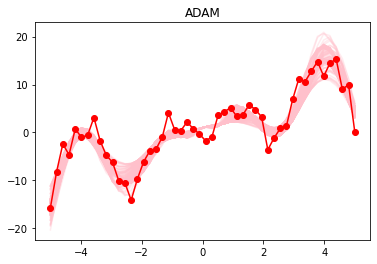

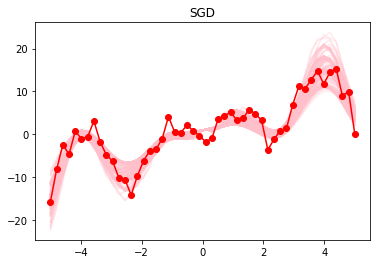

In [166]:
subkey, key = jax.random.split(key)
_, _, thetas_sgd = generate_theta(subkey, params_sgd, n_batch=200)
_, _, thetas = generate_theta(subkey, params, n_batch=200)

plt.figure()
for t in thetas:
    y_adam = f(t)
    plt.plot(x,y_adam, alpha=0.3, color='pink')
plt.plot(x,y, 'ro-')
plt.title('ADAM')

plt.figure()
for t_sgd in thetas_sgd:
    y_sgd = f(t_sgd)
    plt.plot(x,y_sgd, alpha=0.3, color='pink')
plt.plot(x,y, 'ro-')
plt.title('SGD');

In [165]:
params_sgd, params

(DeviceArray([ 1.9268628, -1.1530453], dtype=float32),
 DeviceArray([ 1.9621584, -1.6648203], dtype=float32))